In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'


import joblib, os

In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

## Load Your Saved Joblib File

In [3]:
## Load the joblib file stored in the models folder
fname = "Models/best-models"

loaded = joblib.load(fname)
# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'DecisionTreeRegressor'])

In [4]:
## Saving the loaded objects as separate varaibles
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg_final = loaded['LinearRegression']
dc_reg = loaded['DecisionTreeRegressor']

X_train.head()

Item_Weight  Item_Fat_Content  Item_Visibility  Item_MRP  \
8269    -1.319041          1.363802        -0.043295 -1.268171   
7604    -1.574485         -0.733244         0.248066 -0.459996   
2762    -0.158360         -0.733244        -0.726880  0.182616   
6464    -1.619217         -0.733244         0.511794 -0.192206   
4707     1.266006          1.363802        -0.002094  1.735461   

      Outlet_Establishment_Year  Item_Type_Baking Goods  Item_Type_Breads  \
8269                   0.026015                     1.0               0.0   
7604                   1.338206                     0.0               0.0   
2762                   0.741756                     0.0               0.0   
6464                   0.741756                     0.0               0.0   
4707                   0.741756                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
8269                  0.0               0.0              0.0  ...   
7604                  0.0               0.0              0.0  ...   
2762                  0.0               0.0              0.0  ...   
6464                  0.0               0.0              0.0  ...   
4707                  0.0               0.0              0.0  ...   

      Outlet_Size_MISSING  Outlet_Size_Medium  Outlet_Size_Small  \
8269                  1.0                 0.0                0.0   
7604                  0.0                 1.0                0.0   
2762                  0.0                 0.0                1.0   
6464                  0.0                 0.0                1.0   
4707                  0.0                 0.0                1.0   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
8269                          0.0                          0.0   
7604                          0.0                          0.0   
2762                          0.0                          1.0   
6464                          0.0                          1.0   
4707                          0.0                          1.0   

      Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
8269                          1.0                        1.0   
7604                          1.0                        0.0   
2762                          0.0                        0.0   
6464                          0.0                        0.0   
4707                          0.0                        0.0   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
8269                            0.0                            0.0   
7604                            0.0                            1.0   
2762                            1.0                            0.0   
6464                            1.0                            0.0   
4707                            1.0                            0.0   

      Outlet_Type_Supermarket Type3  
8269                            0.0  
7604                            0.0  
2762                            0.0  
6464                            0.0  
4707                            0.0  

[5 rows x 32 columns]

## Explaining Models with Shap

In [5]:
# Import and init shap
import shap
shap.initjs()

In [6]:
# Take a sample of the training data (nsampel=500, use random_state=SEED)
X_shap = shap.sample(X_train,nsamples = 500,random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

Item_Weight  Item_Fat_Content  Item_Visibility  Item_MRP  \
4469    -1.201325          1.363802         0.159140 -1.023504   
4438    -1.815803         -0.733244        -0.606211  0.388559   
366     -1.123632          1.363802         0.230603  1.884956   
2219    -0.956475         -0.733244        -0.312724 -0.184640   
6080    -1.467363         -0.733244         2.122053 -0.920256   

      Outlet_Establishment_Year  Item_Type_Baking Goods  Item_Type_Breads  \
4469                  -1.286175                     0.0               1.0   
4438                   0.741756                     0.0               0.0   
366                    0.741756                     0.0               0.0   
2219                   0.145305                     0.0               0.0   
6080                   0.026015                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
4469                  0.0               0.0              0.0  ...   
4438                  0.0               0.0              0.0  ...   
366                   0.0               0.0              0.0  ...   
2219                  0.0               0.0              0.0  ...   
6080                  0.0               0.0              0.0  ...   

      Outlet_Size_MISSING  Outlet_Size_Medium  Outlet_Size_Small  \
4469                  0.0                 0.0                0.0   
4438                  0.0                 0.0                1.0   
366                   0.0                 0.0                1.0   
2219                  0.0                 1.0                0.0   
6080                  1.0                 0.0                0.0   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
4469                          0.0                          0.0   
4438                          0.0                          1.0   
366                           0.0                          1.0   
2219                          1.0                          0.0   
6080                          0.0                          0.0   

      Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
4469                          1.0                        0.0   
4438                          0.0                        0.0   
366                           0.0                        0.0   
2219                          0.0                        0.0   
6080                          1.0                        1.0   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
4469                            1.0                            0.0   
4438                            1.0                            0.0   
366                             1.0                            0.0   
2219                            1.0                            0.0   
6080                            0.0                            0.0   

      Outlet_Type_Supermarket Type3  
4469                            0.0  
4438                            0.0  
366                             0.0  
2219                            0.0  
6080                            0.0  

[5 rows x 32 columns]

In [7]:
# Instantiate a Model Explainer with the model
dc_explainer = shap.Explainer(dc_reg)

## Get shap values from the explainer
dc_shap_values = dc_explainer(X_shap)
dc_shap_values[0]

.values =
array([ 4.72421559e+01,  1.97011550e+02, -5.88685266e+01, -9.31490155e+02,
       -3.76623155e+01,  2.74979198e-01, -1.50510831e+00, -3.43039257e-01,
       -1.03610053e+01, -2.32299819e+00, -9.13133535e-02, -3.56338716e+00,
       -2.79909339e+00,  2.92711012e-01,  3.06407032e+01,  1.44297677e-02,
       -2.28900908e-01, -9.00992468e-01,  1.03501272e+01, -1.11034794e+00,
       -2.06693331e+00,  5.47615139e+00, -6.91422240e+01, -3.71133292e+01,
       -1.60251963e+01, -1.03554625e+01, -1.64833683e+00, -1.90839709e+01,
        2.09747263e+02,  1.31219760e+01,  2.35414695e+00, -6.13117694e+01])

.base_values =
array([2153.64301101])

.data =
array([-1.20132496,  1.36380177,  0.15914019, -1.02350384, -1.28617545,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.    

In [8]:
## Create an explainer for the lin_reg
linreg_explainer= shap.Explainer(lin_reg_final, X_shap)

## get shap values for linreg
shap_values_linreg = linreg_explainer(X_shap)
shap_values_linreg.shape

(500, 32)

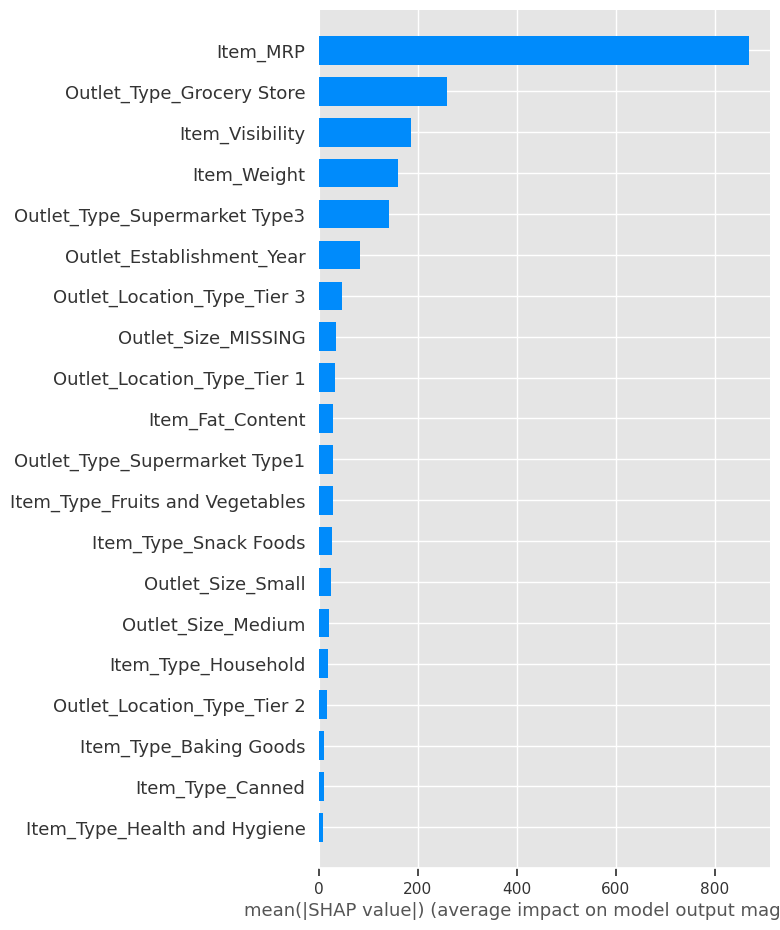

In [9]:
## create a summary plot (bar version)
shap.summary_plot(dc_shap_values, features = X_shap, plot_type='bar')

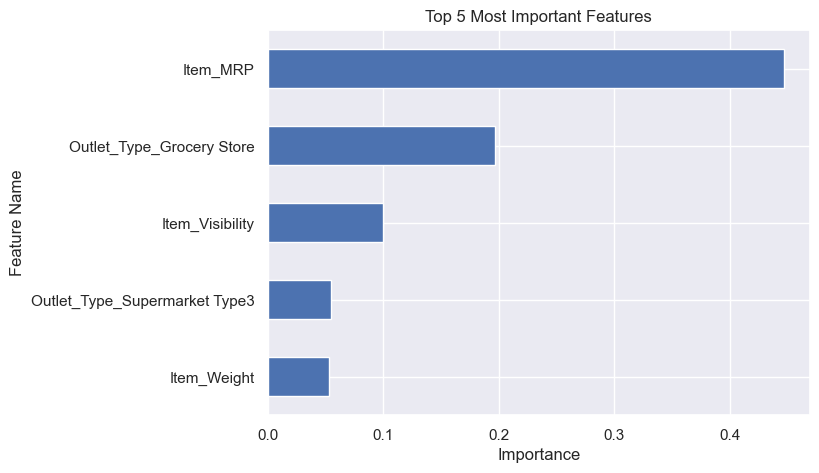

### They are very much the same or close to the same. All the top important features are present in both bar plot.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


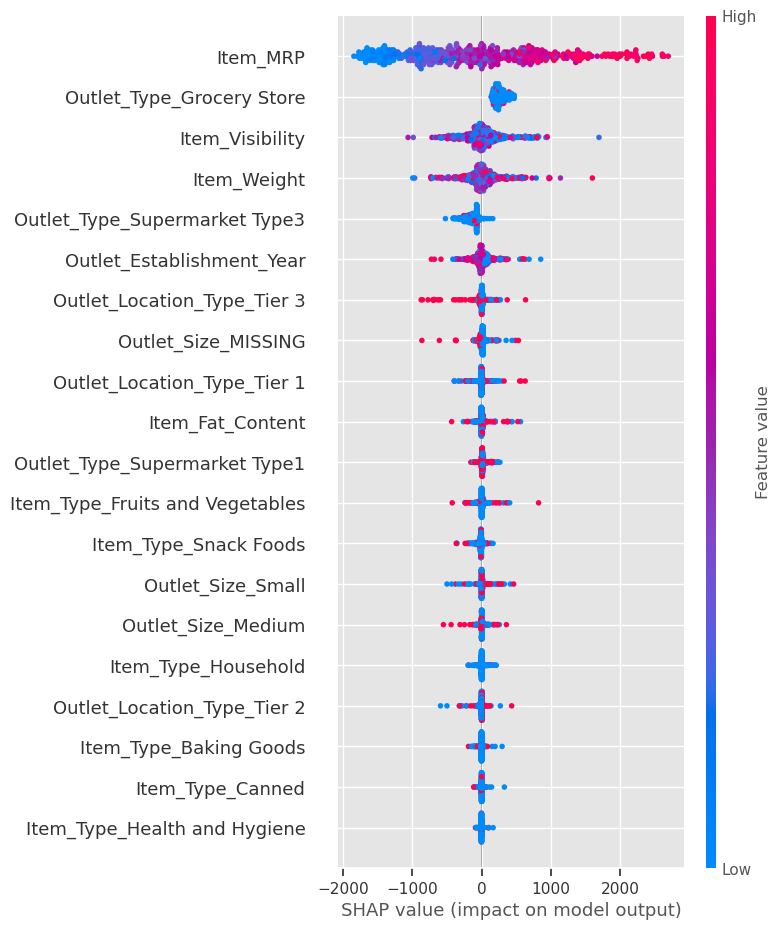

In [10]:
## create a summary plot (dot/default version)
shap.summary_plot(dc_shap_values, features = X_shap)

### It like the most important features are Item_MRP, Item_Visibility, and Item_Weight. They have major impacts on the sales of every store. This makes total sense to me.

# Local Explanation

In [11]:
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

Item_Weight  Item_Fat_Content  Item_Visibility  Item_MRP  \
0    -1.201325          1.363802         0.159140 -1.023504   
1    -1.815803         -0.733244        -0.606211  0.388559   
2    -1.123632          1.363802         0.230603  1.884956   
3    -0.956475         -0.733244        -0.312724 -0.184640   
4    -1.467363         -0.733244         2.122053 -0.920256   

   Outlet_Establishment_Year  Item_Type_Baking Goods  Item_Type_Breads  \
0                  -1.286175                     0.0               1.0   
1                   0.741756                     0.0               0.0   
2                   0.741756                     0.0               0.0   
3                   0.145305                     0.0               0.0   
4                   0.026015                     0.0               0.0   

   Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
0                  0.0               0.0              0.0  ...   
1                  0.0               0.0              0.0  ...   
2                  0.0               0.0              0.0  ...   
3                  0.0               0.0              0.0  ...   
4                  0.0               0.0              0.0  ...   

   Outlet_Size_MISSING  Outlet_Size_Medium  Outlet_Size_Small  \
0                  0.0                 0.0                0.0   
1                  0.0                 0.0                1.0   
2                  0.0                 0.0                1.0   
3                  0.0                 1.0                0.0   
4                  1.0                 0.0                0.0   

   Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
0                          0.0                          0.0   
1                          0.0                          1.0   
2                          0.0                          1.0   
3                          1.0                          0.0   
4                          0.0                          0.0   

   Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
0                          1.0                        0.0   
1                          0.0                        0.0   
2                          0.0                        0.0   
3                          0.0                        0.0   
4                          1.0                        1.0   

   Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
0                            1.0                            0.0   
1                            1.0                            0.0   
2                            1.0                            0.0   
3                            1.0                            0.0   
4                            0.0                            0.0   

   Outlet_Type_Supermarket Type3  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            0.0  

[5 rows x 32 columns]

In [13]:
# what is the max/range of Item Visibility
X_shap_local['Item_Visibility'].describe()

count    500.000000
mean       0.037713
std        1.010289
min       -1.276702
25%       -0.732787
50%       -0.211322
75%        0.699843
max        4.365533
Name: Item_Visibility, dtype: float64

In [18]:
## saving the index of the most visibility
item_high_vis = X_shap_local['Item_Visibility'].idxmax()
item_high_vis

271

In [20]:
## saving the index of the most visibility
item_low_vis = X_shap_local['Item_Visibility'].idxmin()
item_low_vis

45

### I choice Item-Visibility as my high and low example. I believe that the where an item is placed will lead to a bigger selling point.

## Lime

In [22]:
from lime.lime_tabular import LimeTabularExplainer

## Create a lime explainer with X_shap_local with regression as the mode
lime_explainer =LimeTabularExplainer(
    training_data=X_shap_local.values,  
    feature_names=X_shap_local.columns,
   mode='regression'
)
lime_explainer

In [25]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[item_high_vis],
                                      dc_reg.predict)
exp.show_in_notebook()

In [32]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[item_low_vis],
                                      dc_reg.predict)
exp.show_in_notebook()

### According to Sharp the top influencial features are Item_MRP, Outlet_Type_Grocery Store, Item_Visibility, Item_Weight, and Outlet_Type_Grocery Store.

### You can see with more visibility a product sells better with less visibility the item has more negatives going on in the Lime Explorer.

In [33]:
shap.force_plot(linreg_explainer.expected_value,shap_values_linreg.values,X_shap_local,)

In [34]:
shap.force_plot(dc_explainer.expected_value,dc_shap_values.values,X_shap_local,)

### To tell you the truth I don't know what is going on on the force plots. I see larger positive features for the linear regression but more negative features. 